Using device: cuda


C:\Users\Zack\AppData\Roaming\Python\Python312\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting training...
Epoch [5/100], Loss: 0.1934, Best F1: 0.9332
Epoch [10/100], Loss: 0.1742, Best F1: 0.9401
Epoch [15/100], Loss: 0.1597, Best F1: 0.9401
Epoch [20/100], Loss: 0.1533, Best F1: 0.9476
Epoch [25/100], Loss: 0.1487, Best F1: 0.9476
Epoch [30/100], Loss: 0.1466, Best F1: 0.9476
Epoch [35/100], Loss: 0.1440, Best F1: 0.9529
Epoch [40/100], Loss: 0.1428, Best F1: 0.9529
Epoch [45/100], Loss: 0.1412, Best F1: 0.9533
Epoch [50/100], Loss: 0.1391, Best F1: 0.9533
Epoch [55/100], Loss: 0.1389, Best F1: 0.9539
Epoch [60/100], Loss: 0.1376, Best F1: 0.9539
Epoch [65/100], Loss: 0.1369, Best F1: 0.9539
Epoch [70/100], Loss: 0.1362, Best F1: 0.9539
Epoch [75/100], Loss: 0.1355, Best F1: 0.9539
Epoch [80/100], Loss: 0.1348, Best F1: 0.9563
Epoch [85/100], Loss: 0.1352, Best F1: 0.9563
Epoch [90/100], Loss: 0.1334, Best F1: 0.9563
Epoch [95/100], Loss: 0.1343, Best F1: 0.9563
Epoch [100/100], Loss: 0.1334, Best F1: 0.9563

Final Evaluation...

Model Performance:

Classification Re

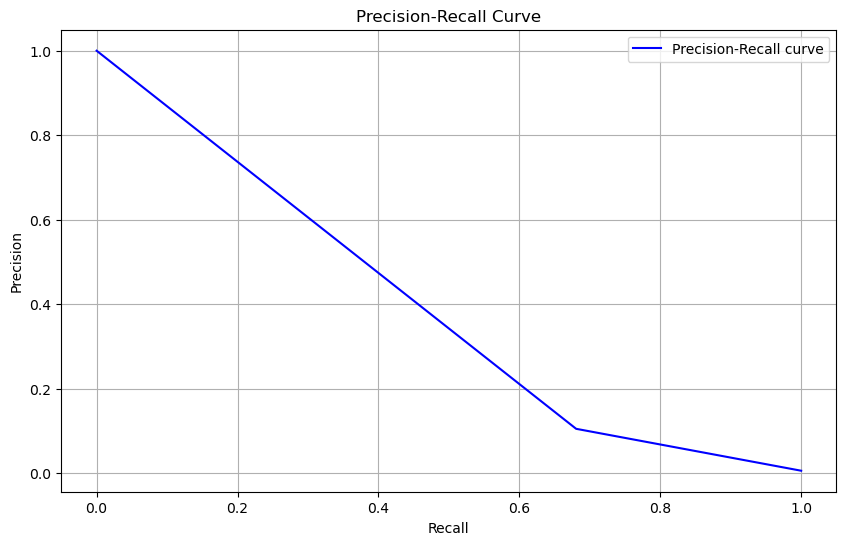


Top 10 Most Important Features:
Material_1: 0.4046
Length: 0.3974
Diameter: 0.3825
Length_Cubed: 0.2866
Material_4: 0.2526
Length_Squared: 0.2298
Material_6: 0.2260
Material_8: 0.2222
Material_9: 0.1986
Material_10: 0.1224

Model Summary:
Total trainable parameters: 695,809
Best F1 Score: 0.9563
Best Threshold: 0.6000


In [5]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.amp as amp
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from torch.optim.lr_scheduler import ReduceLROnPlateau

class TorchOneClassSVM(nn.Module):
    def __init__(self, input_dim):
        super(TorchOneClassSVM, self).__init__()
        self.rbf_layer = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x, chunk_size=128):
        batch_predictions = []
        
        for i in range(0, x.size(0), chunk_size):
            end_idx = min(i + chunk_size, x.size(0))
            chunk = x[i:end_idx]
            
            with amp.autocast(device_type='cuda'):
                output = self.rbf_layer(chunk)
            
            batch_predictions.append(output)
            
        return torch.cat(batch_predictions, dim=0)

# Set up GPU and memory optimization
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
grad_scaler = amp.GradScaler()

print(f"Using device: {device}")
torch.cuda.empty_cache()

# Load and preprocess data
df = pd.read_csv('water_main_data.csv')
df['Length'] = df['Length'].astype(str).str.replace(' ft', '').astype(float)
df = df[df['Material'] != 'UNKNOWN']

# Feature engineering
df['Length_Squared'] = df['Length'] ** 2
df['Length_Cubed'] = df['Length'] ** 3

# Encode Material column
material_encoder = OneHotEncoder(sparse_output=False)
material_encoded = material_encoder.fit_transform(df['Material'].values.reshape(-1, 1))
material_columns = [f'Material_{i}' for i in range(material_encoded.shape[1])]
df_encoded = pd.DataFrame(material_encoded, columns=material_columns)

df = pd.concat([df, df_encoded], axis=1)
df['Installed'] = pd.to_datetime(df['Installed'])
df['Year_Installed'] = df['Installed'].dt.year
df['Age'] = 2024 - df['Year_Installed']
df = df.drop(columns=['Material', 'Installed'])

# Prepare features and target
X = df.drop(columns=['ID', 'Leak Occurred'])
y = df['Leak Occurred']

# Preprocessing
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Apply SMOTE for balancing
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_imputed, y)

# Scale features
min_max_scaler = MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X_balanced)

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X_scaled).to(device)
y_tensor = torch.FloatTensor(y_balanced.values).to(device)

# Create DataLoader with GPU optimization
batch_size = 512
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=False,
    num_workers=0
)

# Calculate class weights
pos_weight = torch.tensor([(y_balanced == 0).sum() / (y_balanced == 1).sum()]).to(device)

# Initialize model and move to GPU
model = TorchOneClassSVM(input_dim=X_tensor.shape[1]).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Training loop with GPU optimization
num_epochs = 100
best_f1 = 0
best_threshold = 0.5
patience = 10
patience_counter = 0

print("Starting training...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        
        with amp.autocast(device_type='cuda'):
            logits = model(batch_x)
            loss = criterion(logits.squeeze(), batch_y)
        
        grad_scaler.scale(loss).backward()
        grad_scaler.step(optimizer)
        grad_scaler.update()
        
        total_loss += loss.item()
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    if (epoch + 1) % 5 == 0:
        model.eval()
        with torch.no_grad():
            val_logits = model(X_tensor)
            val_predictions = torch.sigmoid(val_logits)
            
            current_best_f1 = best_f1
            for threshold in np.arange(0.3, 0.7, 0.05):
                pred_binary = (val_predictions.squeeze().cpu().numpy() > threshold).astype(int)
                f1 = f1_score(y_balanced, pred_binary)
                
                if f1 > best_f1:
                    best_f1 = f1
                    best_threshold = threshold
            
            if best_f1 <= current_best_f1:
                patience_counter += 1
            else:
                patience_counter = 0
                
            scheduler.step(best_f1)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}, Best F1: {best_f1:.4f}')
        
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Final evaluation
print("\nFinal Evaluation...")
model.eval()
with torch.no_grad():
    final_logits = model(torch.FloatTensor(min_max_scaler.transform(X_imputed)).to(device))
    final_predictions = torch.sigmoid(final_logits)
    final_predictions = (final_predictions.squeeze().cpu().numpy() > best_threshold).astype(int)

# Calculate metrics
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt

print("\nModel Performance:")
print("\nClassification Report:")
print(classification_report(y, final_predictions))
print("\nConfusion Matrix:")
print(confusion_matrix(y, final_predictions))

# Plot Precision-Recall curve
precisions, recalls, thresholds = precision_recall_curve(y, final_predictions)
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, 'b-', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()

# Save model and results
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_threshold': best_threshold,
    'best_f1': best_f1,
    'scaler': min_max_scaler
}, 'leak_detection_model.pth')

# Save predictions
df['Predicted_Leak'] = final_predictions
df['Leak_Probability'] = torch.sigmoid(final_logits).squeeze().cpu().numpy()
df.to_csv('predicted_leaks_improved.csv', index=False)

# Print feature importance (based on weights of first layer)
feature_names = X.columns.tolist()
first_layer_weights = abs(model.rbf_layer[0].weight.cpu().detach().numpy())
feature_importance = np.mean(first_layer_weights, axis=0)
feature_importance_dict = dict(zip(feature_names, feature_importance))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

print("\nTop 10 Most Important Features:")
for feature, importance in sorted_features[:10]:
    print(f"{feature}: {importance:.4f}")

# Clean up GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Print model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("\nModel Summary:")
print(f"Total trainable parameters: {count_parameters(model):,}")
print(f"Best F1 Score: {best_f1:.4f}")
print(f"Best Threshold: {best_threshold:.4f}")